# Noun Compound Classification

In [107]:
# Imports
import re
import pandas as pd
import numpy as np
import os
import json

from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

from collections import Counter

from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from multiprocessing import  Pool
from functools import partial
import numpy as np
from keras.utils.np_utils import to_categorical

# set GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7376182044224797097
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6281357472747281360
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [108]:
! pip install keras-self-attention
from keras_self_attention import SeqSelfAttention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.49.0-cp37-none-any.whl size=19468 sha256=cf101a84aa9a7ef35c4ff2227e8a7075ca5231754ecdb963213b2cc60b09145c
  Stored in directory: /root/.cache/pip/wheels/6f/9d/c5/26693a5092d9313daeae94db04818fc0a2b7a48ea381989f34
Successfully built keras-self-attention


In [80]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/nnc_data'
embed_path = '/content/drive/MyDrive/glove.6B.50d.txt'
print(os.listdir(data_dir))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['test.json', 'train.json', 'lstm_checkpoint.index', 'lstm_checkpoint.data-00000-of-00001', 'checkpoint', 'lstm_predictions.json']


In [166]:
embed_size = 50
max_words = 50000
SEED = 42
k=15 # no. of context sentences to be picked.
input_data_context = True
model_name = 'simple_lstm'
lstm_rep_size = 32

### Data Processing

In [167]:
train_json_file = os.path.join(data_dir, 'train.json')
test_json_file = os.path.join(data_dir, 'test.json')

with open(train_json_file, 'r') as f:
    train_json = json.load(f)

with open(test_json_file, 'r') as f:
    test_json = json.load(f)

In [168]:
print(len(train_json), type(train_json))
print(len(test_json), type(test_json))

16284 <class 'list'>
2874 <class 'list'>


In [169]:
def get_context(entry):
    sentence_list = entry['context']
    sents = [sent.strip() for sent in sentence_list]
    num_sents = len(sents)
    sents = sents[:min(k, num_sents)]
    merged = ' '.join(sents)
    return merged

def get_label(entry):
    if 'label' in entry.keys():
        return entry['label']
    else:
        return None

def get_nc(entry):
    return entry['nc']

In [170]:
def parse_json_to_df(data_json):
    data = {
        'input' : [],
        'label' : [],
    }

    if input_data_context:
        data['input'] = [get_context(entry) for entry in data_json]
    else:
        data['input'] = [get_nc(entry) for entry in data_json]  
    data['label'] = [get_label(entry) for entry in data_json]
    df = pd.DataFrame(data)
    return df

In [171]:
train_df = parse_json_to_df(train_json)
test_df = parse_json_to_df(test_json)
print(train_df.head(5))
print(test_df.head(5))

                                               input                         label
0  At the time, he stated he intended to keep the...                   LEXICALIZED
1  The National Anti-Drug Office or ONA (in Spani...  CREATE-PROVIDE-GENERATE-SELL
2  Chrysalis Dorsal Ventral Mounted "NatureServe ...                     OBJECTIVE
3  A study of the supervision of the Foreign Mark...                     OBJECTIVE
4  The debt service coverage ratio (DSCR), also k...                     OBJECTIVE
                                               input label
0  He was Chief magistrate of Anguilla from 1842 ...  None
1  He escapes at the last minute and sets light t...  None
2  Ambassador Apakan is the Chief Monitor of the ...  None
3  Education in Wales Estyn welcomes new chief in...  None
4  Their Social Splash (1915) Back Stage (1917) T...  None


In [172]:
def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

In [173]:
train_df["input"] = train_df["input"].apply(lambda x: clean_text(x))
test_df["input"] = test_df["input"].apply(lambda x: clean_text(x))

In [174]:
train_x, val_x, train_y, val_y = train_test_split(train_df['input'], train_df['label'],
                                                    stratify=train_df['label'], 
                                                    random_state = SEED,
                                                    test_size=0.25)

In [175]:
max_len_tr = max(len(i.split(' ')) for i in train_df["input"])
max_len_ts = max(len(i.split(' ')) for i in test_df["input"])
print('Longest train sentence: ', max_len_tr)
print('Longest test sentence: ', max_len_ts)
max_len = max(max_len_tr, max_len_ts)

tokenizer = Tokenizer(max_words)
tokenizer.fit_on_texts(list(train_x))
train_x = tokenizer.texts_to_sequences(train_x)
val_x = tokenizer.texts_to_sequences(val_x)

# Tokenize test data based on train tokenizer?
test_x = tokenizer.texts_to_sequences(test_df['input'])

train_x = np.asarray(pad_sequences(train_x, maxlen=max_len))
val_x = np.asarray(pad_sequences(val_x, maxlen=max_len))
test_x = np.asarray(pad_sequences(test_x, maxlen=max_len))

Longest train sentence:  16255
Longest test sentence:  4674


In [176]:
le = LabelEncoder()
train_y = to_categorical(le.fit_transform(train_y.values))
val_y = to_categorical(le.transform(val_y.values))

In [177]:
no_of_classes=len(le.classes_)
print('Number of classes: ', no_of_classes)

Number of classes:  37


In [178]:
def load_glove(word_index):
    EMBEDDING_FILE = embed_path
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = max_words
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_words: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [179]:
embedding_matrix = load_glove(tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Model

In [180]:
print(model_name)
if model_name == 'simple_ff':
    e = Embedding(max_words, embed_size, weights=[embedding_matrix], input_length=4, trainable=False)
    model = Sequential()
    model.add(e)
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(no_of_classes,activation='softmax'))
elif model_name == 'lstm':
    # input length need not be fixed, using LSTM after embedding
    e = Embedding(max_words, embed_size, weights=[embedding_matrix], trainable=False)
    model = Sequential()
    model.add(e)
    model.add(LSTM(lstm_rep_size))
    # final hidden layer representation has dimensions 32x1
    model.add(Dense(lstm_rep_size, activation='relu'))
    model.add(Dense(no_of_classes, activation='softmax'))
elif model_name == 'bidir_lstm':
    # input length need not be fixed, using LSTM after embedding
    e = Embedding(max_words, embed_size, weights=[embedding_matrix], trainable=False)
    model = Sequential()
    model.add(e)
    model.add(Bidirectional(LSTM(lstm_rep_size)))
    # final hidden layer representation has dimensions 32x1
    model.add(Dense(lstm_rep_size, activation='relu'))
    model.add(Dense(no_of_classes, activation='softmax'))
elif model_name == 'self_attn':
    e = Embedding(max_words, embed_size, weights=[embedding_matrix], input_length=max_len, trainable=False)
    model = Sequential()
    model.add(e)
    model.add(LSTM(lstm_rep_size, return_sequences=True))
    model.add(SeqSelfAttention(attention_width=5,attention_activation='sigmoid'))
    model.add(Lambda(lambda x:x[:,0,:]))
    model.add(Dense(lstm_rep_size, activation='relu'))
    model.add(Dense(no_of_classes, activation='softmax'))
else:
    raise NotImplementedError

simple_lstm


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 50)          2500000   
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                10624     
_________________________________________________________________
dense_27 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_28 (Dense)             (None, 37)                1221      
Total params: 2,512,901
Trainable params: 12,901
Non-trainable params: 2,500,000
_________________________________________________________________
None


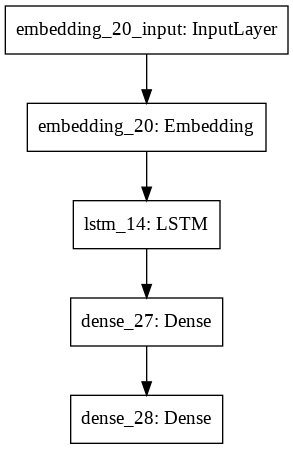

In [181]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
plot_model(model)

### Training and Testing

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=50, verbose=0)
checkpoint_filepath = os.path.join(data_dir, '%s_checkpoint' % model_name)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)
with tf.device('/gpu:0'):
    model.load_weights(checkpoint_filepath)
    history = model.fit(train_x, train_y , validation_data = (val_x, val_y),
                    epochs=100, callbacks=[es, model_checkpoint_callback])

Epoch 1/100
382/382 [==============================] - 180s 471ms/step - loss: 1.3764 - accuracy: 0.5921 - val_loss: 3.0705 - val_accuracy: 0.3102
Epoch 2/100
382/382 [==============================] - 180s 471ms/step - loss: 1.3410 - accuracy: 0.6026 - val_loss: 3.0805 - val_accuracy: 0.3122
Epoch 3/100
382/382 [==============================] - 180s 471ms/step - loss: 1.3393 - accuracy: 0.6020 - val_loss: 3.1096 - val_accuracy: 0.3154
Epoch 4/100
382/382 [==============================] - 180s 470ms/step - loss: 1.3385 - accuracy: 0.6057 - val_loss: 3.1248 - val_accuracy: 0.3129
Epoch 5/100
382/382 [==============================] - 180s 472ms/step - loss: 1.3167 - accuracy: 0.6083 - val_loss: 3.1402 - val_accuracy: 0.3174
Epoch 6/100
382/382 [==============================] - 180s 472ms/step - loss: 1.3220 - accuracy: 0.6083 - val_loss: 3.1421 - val_accuracy: 0.3117
Epoch 7/100
382/382 [==============================] - 180s 470ms/step - loss: 1.3107 - accuracy: 0.6103 - val_loss: 3

In [ ]:
## prediction on test and saving outputs in test json format
model.load_weights(checkpoint_filepath)
preds = model.predict_classes(test_x, verbose=1)

In [ ]:
print(checkpoint_filepath)
print(type(preds), len(preds))
print(preds[0])
preds = le.inverse_transform(preds)
print(preds[0])

In [ ]:
# save preds to new test json
save_pred = os.path.join(data_dir, '%s_predictions.json' % model_name)
output_list = []
for i, item in enumerate(test_json):
    item['label'] = preds[i]
    output_list.append(item)
with open(save_pred, 'w') as f:
    json.dump(output_list, f, indent=4)